In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from scipy.stats import norm
import scipy.optimize as opt
import scipy.stats    as st
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

from pyDOE import *
import gpflow as gp
from scipy.spatial import distance_matrix

# plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

In [2]:
import matplotlib as mpl

cmap_blues = mpl.cm.Blues(np.linspace(0,1,20))
cmap_blues = mpl.colors.ListedColormap(cmap_blues[5:,:-1])

cmap_oranges = mpl.cm.Oranges(np.linspace(0,1,20))
cmap_oranges = mpl.colors.ListedColormap(cmap_oranges[5:,:-1])

cmap_greys = mpl.cm.Greys(np.linspace(0,1,20))
cmap_greys = mpl.colors.ListedColormap(cmap_greys[5:,:-1][::-1])

In [3]:
def find_levels(x, y, contours = [.99, .90, .68], **kwargs):
    # Make a 2d normed histogram
    if kwargs.get('energy', None) is None:
        H,xedges,yedges=np.histogram2d(x,y,bins=20,normed=True)
    else:
        H = np.exp(-kwargs.get('energy'))

    norm=H.sum() # Find the norm of the sum
    # Set target levels as percentage of norm
    targets = [norm * c for c in contours]
    # Take histogram bin membership as proportional to Likelihood
    # This is true when data comes from a Markovian process
    def objective(limit, target):
        w = np.where(H>limit)
        count = H[w]
        return count.sum() - target

    # Find levels by summing histogram to objective
    levels = [opt.bisect(objective, H.min(), H.max(), args=(target,)) for target in targets]

    # For nice contour shading with seaborn, define top level
    levels.append(H.max())

    if kwargs.get('energy', None) is None:
        return levels
    else:
        return -np.log(levels)[::-1]

In [4]:
import sys
sys.path.append('/Users/agarbuno/postdoc/python/modules/ipuq/')

In [5]:
%load_ext autoreload
%autoreload 2
from ces.utils import *
from ces.calibrate import *
import ces.emulate as emu
from ces.sample import *

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
save_figs = False

<a id='contents'></a> 
# Table of contents

1. **[Calibrate](#calibrate)**  
2. **[Emulate](#emulate)**  
    **2.1. [Linear prior](#linear-emulate-all)**  
    **2.2. [Mixed prior](#mixed-emulate-all)**  
    **2.3. [Time variability](#time-var)**  
    **2.4. [Parameter variability](#par-var)**
3. **[Sample](#sample)**


<a id='calibrate'></a> 
#  Calibrate

[go back](#contents)

In [7]:
T     = 360.                                # Final time
dt    = 100.                               # Timesteps in each time unit
steps = int(T * dt)                        # Overall number of steps
t     = np.linspace(0, T, steps + 1)       # time array

T_roll   = 10.
T_spinup = 30.

w0 = (1., 1., 1.)                          # Initial conditions

In [8]:
model          = lorenz63_log()
model.l_window = T_roll
model.freq     = dt

ws = model.solve(w0, t)
y  = model.statistics(ws)

In [9]:
n_obs = 9                               # number of observations
ustar = np.array([[np.log(28.)], [np.log(8./3)]])      # true parameters
p = 2                                   # parameter dimensionality

# Generate data
np.random.seed(1)
# ws = integrate.odeint(lorenz2d, w0, t, args = (28., 8./3))
xs, ys, zs = ws[:,0], ws[:,1], ws[:,2]
ws = [xs, ys, zs, xs**2, ys**2, zs**2, xs*ys, xs*zs, ys*zs]

# Compute the means of windows of size 10. 
# Allow for a spinup of 30 units of time and gather results
wt = np.asarray([xs[-1], ys[-1], zs[-1]])
gs = [np.asarray(pd.Series(k).rolling(window = int(T_roll * dt)).mean()) for k in ws]
Gamma = np.cov(np.asarray(gs)[:,t>T_spinup])
# y_obs = np.asarray(gs)[:,-1]
y_obs = np.asarray(gs)[:,t>T_spinup].mean(axis = 1)

In [21]:
y_obs

array([3.94147535e-01, 3.91695570e-01, 2.36145907e+01, 6.29755846e+01,
       8.08477294e+01, 6.30906624e+02, 6.29763245e+01, 1.06691603e+01,
       1.02856931e+01])

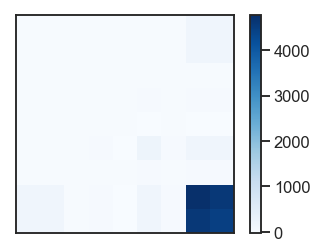

In [10]:
plt.imshow(Gamma, cmap = 'Blues')
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.colorbar();

In [32]:
Jnoise = np.linalg.cholesky(Gamma)
J      = 100

T_eks     = 60
steps_eks = int(T_eks * dt)                     
t_eks     = np.linspace(0, T_eks, steps_eks + 1)

enki = sampling(p = p, n_obs = n_obs, J = J)
enki.ustar    = ustar
enki.T        = 50
enki.mu       = np.array([3.3, 1.2]).reshape(2,-1)
enki.sigma    = np.diag([0.15**2, 0.5**2])

enki.parallel = True
enki.mute_bar = True

np.random.seed(2016)
# np.random.seed(1988)
# U0 = np.random.uniform(1,30, [enki.p, enki.J])
U0 = enki.mu + enki.sigma**0.5 @ np.random.normal(0, 1, [enki.p, enki.J])

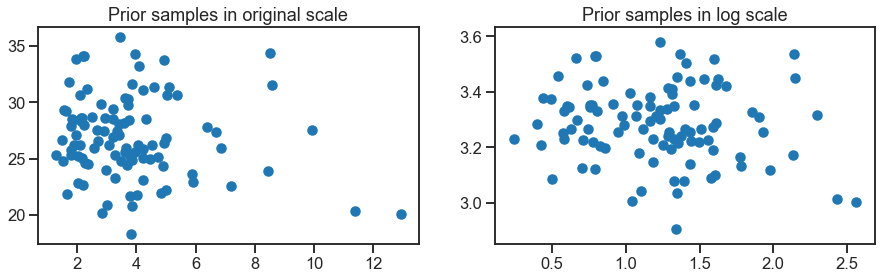

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
axes[0].scatter(np.exp(U0[1]), np.exp(U0[0]))
axes[0].set_title('Prior samples in original scale');
axes[1].scatter(U0[1], U0[0])
axes[1].set_title('Prior samples in log scale');

In [ ]:
# enki.run(y_obs, U0, model, Gamma, Jnoise, wt = wt, t = t_eks, update = 'eks-jacobian')
enki.run(y_obs, U0, model, Gamma, Jnoise, wt = wt, t = t_eks)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
axes[0].scatter(np.exp(U0[1]), np.exp(U0[0]))
axes[1].scatter(U0[1], U0[0])

axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]))
axes[1].scatter(enki.Ustar[1], enki.Ustar[0])

axes[0].set_title('Original scale');
axes[1].set_title('Log scale');

In [15]:
enki.Ustar.max(axis = 1)

array([3.34480237, 1.02371959])

In [16]:
# b \in [25, 30]
logr_lo = 2.8
logr_up = 3.8

# b \in [2, 4]
logb_lo = 0.0
logb_up = 3.0

# b \in [25, 30]
logr_lo = 3.31
logr_up = 3.35

# b \in [2, 4]
logb_lo = 0.92
logb_up = 1.05

# # b \in [25, 30]
# logr_lo = np.log(25.)
# logr_up = np.log(30.)

# # b \in [2, 4]
# logb_lo = np.log(2.)
# logb_up = np.log(4.)


grid_size = 60
rs, bs = np.meshgrid(np.linspace(logr_lo, logr_up, grid_size),
                   np.linspace(logb_lo, logb_up, grid_size))

In [17]:
enki.mute_bar = False       # Let us show the progress evaluation meter. 

Gs = enki.G_pde_ens(np.vstack([np.array([rs.flatten(), bs.flatten()]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size**2,replace=True)]]), 
                   model, t_eks)

In [18]:
rb_ = np.vstack([np.array([rs.flatten(), bs.flatten()])]).T

prior = multivariate_normal(mean = enki.mu.flatten(), cov = enki.sigma)
logprior = prior.logpdf(rb_)
logjac = -rb_.sum(axis = 1)

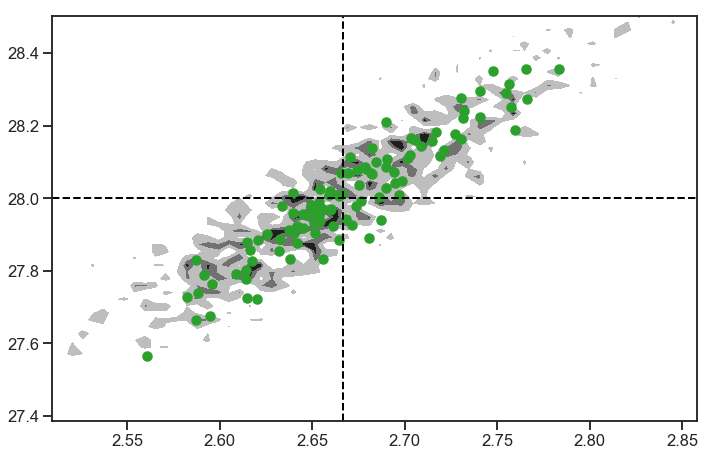

In [19]:
Phi = ((Gs[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)
pltlevels = np.log(find_levels(rs, bs, energy = Phi - logprior - logjac))

fig, ax = plt.subplots(1,1,figsize=(10, 7));
cmap = plt.get_cmap('gray')
plt.contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
                      pltlevels, extend = 'min', cmap = cmap_greys)
# plt.colorbar();

plt.scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c')

ax.axvline(x = np.exp(ustar[1]), linestyle = '--', color = 'black', linewidth = 2)    
ax.axhline(y = np.exp(ustar[0]), linestyle = '--', color = 'black', linewidth = 2)

# plt.title('EKS output, last iteration.');
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-phi-noise-alt'
# plt.savefig(paper_directory+file+'.png', dpi=150)

rlims = ax.get_xlim()
blims = ax.get_ylim()

In [20]:
# rs
grid_size = 240

Gs_r = enki.G_pde_ens(np.vstack([np.array([np.linspace(logr_lo, logr_up, grid_size), 
                                           np.log(8./3) * np.ones(grid_size)]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size,replace=True)]]), 
                   model, t_eks)
# bs
np.linspace(logb_lo, logb_up, grid_size)
Gs_b = enki.G_pde_ens(np.vstack([np.array([np.log(28.) * np.ones(grid_size), 
                                           np.linspace(logb_lo, logb_up, grid_size)]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size,replace=True)]]), 
                   model, t_eks)

In [21]:
Phi_r = ((Gs_r[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs_r[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)
Phi_b = ((Gs_b[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs_b[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)


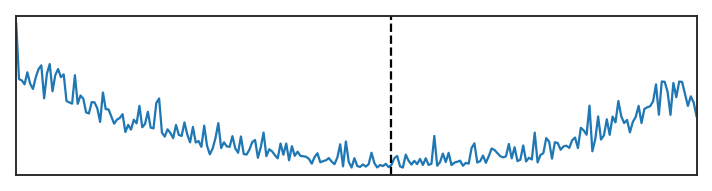

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10, 3));

plt.plot(np.exp(np.linspace(logr_lo, logr_up, grid_size)), Phi_r)
plt.xlim(blims)
ax.set_xticks([]);
ax.set_yticks([]);
ax.axvline(28.0, linestyle = '--', color = 'black')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-phib-rfixed'
# plt.savefig(paper_directory+file+'.png', dpi=150)

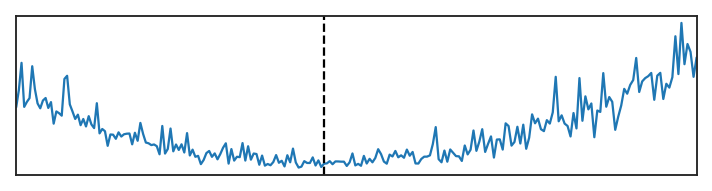

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 3));

plt.plot(np.exp(np.linspace(logb_lo, logb_up, grid_size)), Phi_b)
plt.xlim(rlims)
ax.set_xticks([]);
ax.set_yticks([]);
ax.axvline(8./3, linestyle = '--', color = 'black')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-rhib-bfixed'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [24]:
import matplotlib.gridspec as gridspec

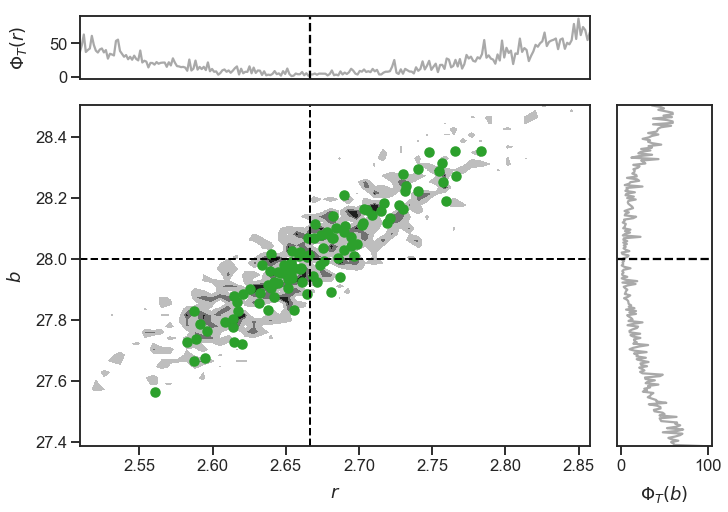

In [25]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True);

gs = fig.add_gridspec(4, 4)
#  -------------------------------------------

f_ax1 = fig.add_subplot(gs[1:, :3])
grid_size = 60
cmap = plt.get_cmap('gray')
f_ax1.contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
                      pltlevels, extend = 'min', cmap = cmap_greys)
f_ax1.scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c')
f_ax1.axvline(x = np.exp(ustar[1]), linestyle = '--', color = 'black', linewidth = 2)    
f_ax1.axhline(y = np.exp(ustar[0]), linestyle = '--', color = 'black', linewidth = 2)
f_ax1.set_ylabel(r"$b$", labelpad=10)
f_ax1.set_xlabel(r"$r$", labelpad=10)


#  -------------------------------------------
f_axr = fig.add_subplot(gs[1:, 3])
grid_size = 240
f_axr.plot(Phi_r, np.exp(np.linspace(logr_lo, logr_up, grid_size)), 'darkgray')
f_axr.set_ylim(blims)
# f_axr.set_xticks([]);
f_axr.set_yticks([]);
f_axr.set_xlabel(r"$\Phi_T(b)$", labelpad=10)
f_axr.axhline(28.0, linestyle = '--', color = 'black')

#  -------------------------------------------
f_axb = fig.add_subplot(gs[0, :3])
f_axb.plot(np.exp(np.linspace(logb_lo, logb_up, grid_size)), Phi_b, 'darkgray')
f_axb.set_xlim(rlims)
f_axb.set_xticks([]);
# f_axb.set_yticks([]);
f_axb.set_ylabel(r"$\Phi_T(r)$", labelpad=20)
f_axb.axvline(8./3, linestyle = '--', color = 'black')

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-calibrate-eks'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [26]:
grid_size = 60

<a id='emulate'></a>
# 2. Emulate
[go back](#contents)

In [27]:
def invgamma_roots(theta, locs): 
    gamma_ = st.invgamma(np.exp(theta[0]), scale = np.exp(theta[1]))
    locs_  = locs
    return [      gamma_.cdf(locs_[0]) - .010, 
             1. - gamma_.cdf(locs_[1]) - .010]

In [28]:
lenghtscale_params = []
for thetas in enki.Ustar: 
    dmatrix = distance_matrix(np.exp(thetas).reshape(-1,1), np.exp(thetas).reshape(-1,1))
    ilocs = [1/(dmatrix[dmatrix > 0].max()), 1/(100 * dmatrix[dmatrix > 0].min())]
    soli = opt.root(invgamma_roots, [0, 0], method = 'hybr', args = (ilocs))
    lenghtscale_params.append(np.array([np.exp(soli.x[0]), np.exp(-soli.x[1])]))

In [29]:
lenghtscale_params = np.array(lenghtscale_params).T
lenghtscale_params

array([[1.67392538, 2.73531871],
       [0.13139397, 0.0027713 ]])

In [30]:
np.array(lenghtscale_params).prod(axis = 0)

array([0.21994369, 0.0075804 ])

In [31]:
list(lenghtscale_params[0])

[1.6739253838140766, 2.7353187094489018]

<a id='linear-emulate-all'></a>
## 2.1. Linear mean prior for all components

In [32]:
gp.reset_default_graph_and_session()

In [33]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in tqdm(enumerate(enki.Gstar[range(enki.n_obs)]), desc = 'GP training: ', total = enki.n_obs):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = Gamma[ii,ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [34]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 236.116508
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 236.116508
  Number of iterations: 35
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 235.912704
  Number of iterations: 34
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 235.912704
  Number of iterations: 34
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 63.494998
  Number of iterations: 77
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 63.494998
  Number of iterations: 77
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 191.270629
  Number of iterations: 70
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 191.270629
  Number of iterations: 70
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 226.818052
  Number of iterations: 85
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 226.818052
  Number of iterations: 85
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 406.523049
  Number of iterations: 87
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 406.523049
  Number of iterations: 87
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 196.808393
  Number of iterations: 82
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 196.808393
  Number of iterations: 82
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 565.854686
  Number of iterations: 29
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 565.854686
  Number of iterations: 29
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 561.871850
  Number of iterations: 32
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 561.871850
  Number of iterations: 32
  Number of functions evaluations: 36


In [35]:
gpmeans, gpvars = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

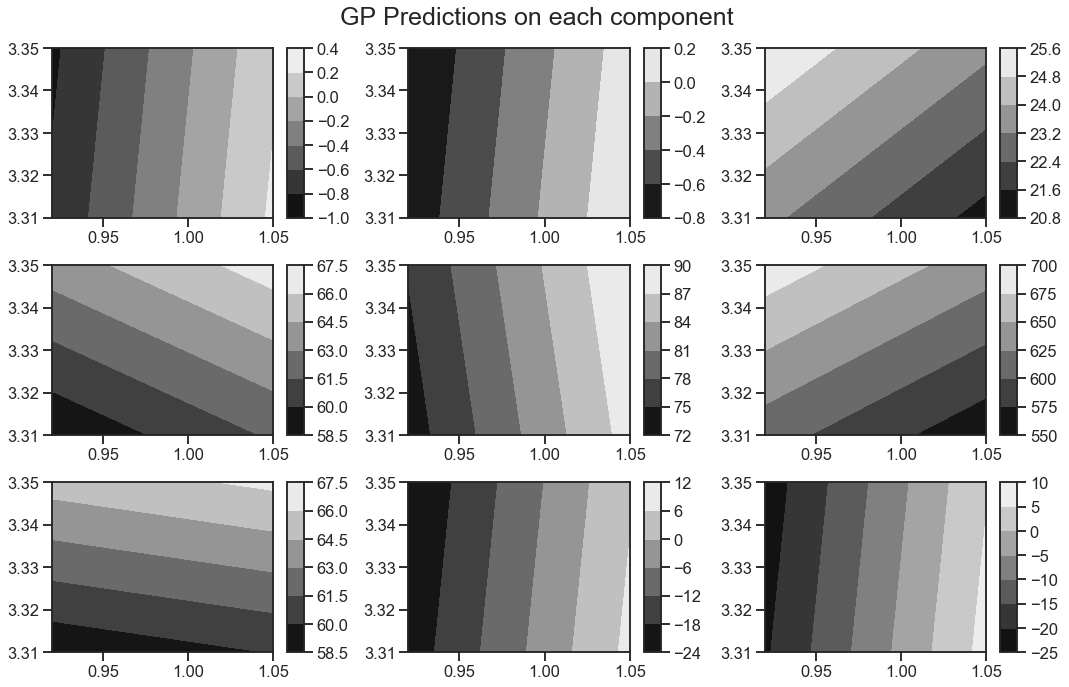

In [36]:
grid_size = 60

fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                gpmeans[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on each component', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [37]:
gplot, varplot = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

In [38]:
DGamma = Gamma - Gamma#- np.diag(np.diag(Gamma))

In [39]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)

for ii in tqdm(range(len(varplot.T))):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varplot[:,ii])))
    
Hplots = {}
Hplots['indp'] = [np.copy(Hplot), np.copy(Hplot_full)]

In [40]:
def plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes, **kwargs):
    k = kwargs.get('k', '')
    cmap = plt.get_cmap('gray');
    im = axes[0].contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
                      pltlevels, extend = 'min',
                      cmap = cmap_greys);

    axes[0].set_title(r'$\Phi_T(\theta; y)$'+'\n');
    axes[0].set_ylabel(k);
    axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
#     plt.colorbar(im, cmap = cmap, ax= axes[0], aspect = 10)

    levels_m = np.log(find_levels(bs, rs, energy = Hplot_rec - logprior - logjac))
    im = axes[1].contourf(np.exp(bs), np.exp(rs), np.log((Hplot_rec - logprior - logjac).reshape(grid_size, grid_size)), 
                          levels_m, extend = 'min',
                      cmap = cmap_greys);
    axes[1].set_title(r'$\Phi_{\mathsf{m}}(\theta; y)$'+'\n');
#     plt.colorbar(im, cmap = cmap, ax= axes[1], aspect = 10)
    axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

    levels_gp = np.log(find_levels(bs, rs, energy = Hplot_full_rec - logprior -logjac - Hplot_full_rec.min()))    
    im = axes[2].contourf(np.exp(bs), np.exp(rs), np.log((Hplot_full_rec - logprior -logjac - Hplot_full_rec.min()).reshape(grid_size, grid_size)), 
                          levels_gp, extend = 'min',
                      cmap = cmap_greys);
    axes[2].set_title(r'$\Phi_{\mathsf{GP}}(\theta; y)$'+'\n');
    axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
#     plt.colorbar(im, cmap = cmap, ax= axes[2], aspect = 10)

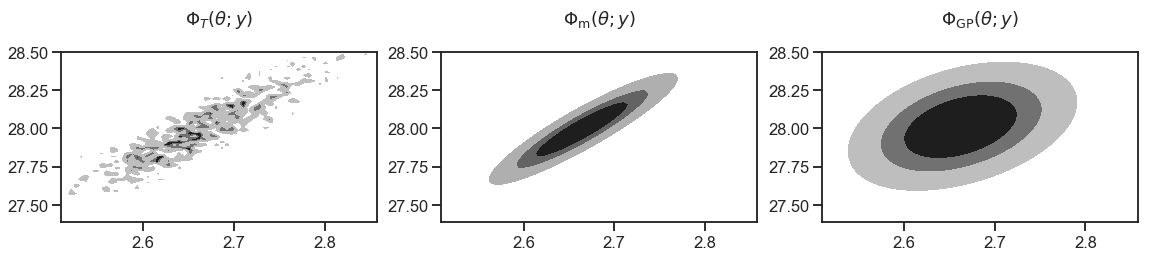

In [41]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot, Hplot_full, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_independent'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [42]:
gpmodels = {}
gpmodels['indp'] = enki.gpmodels

<a id='time-var'></a>
# 2.3 Time variability diagonalization, wrt: $\Sigma$

From the long time data we can estimate the noise component of the shorter time-average model evaluations, which produces our observation covariance matrix $\Sigma$. We can diagonalize the matrix to obtain 

$$ \Sigma = Q \tilde \Sigma Q^\top, $$

where all matrices are of comforming sizes. That is, $Q\in \mathbb{R}^{p \times p}$ and $\tilde \Sigma \in \mathbb{R}^{p \times p }$, where $\tilde \Sigma$ is an invertible diagonal matrix and $Q$ is an orthogonal matrix.  

Using such diagonalization we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|\tilde y - \tilde G(\theta) \|^2_{\tilde \Sigma}, 
\end{align}
$$

where $\tilde y = Q^\top \, y $ and $\tilde G(\theta) = Q^\top \, G(\theta)$

[go back](#contents)

In [43]:
u,d,_ = np.linalg.svd(Gamma)

In [44]:
enki.Y = u.T.dot(enki.Gstar)

In [45]:
yhat = u.T.dot(y_obs)
Sigmahat = np.diag(d)

In [46]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in tqdm(enumerate(enki.Y[range(enki.n_obs)]), desc = 'GP training: ', total = enki.n_obs):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = d[ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [47]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 598.473981
  Number of iterations: 33
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 598.473981
  Number of iterations: 33
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 411.694964
  Number of iterations: 95
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 411.694964
  Number of iterations: 95
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 267.137507
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 267.137507
  Number of iterations: 34
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 236.493521
  Number of iterations: 82
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 236.493521
  Number of iterations: 82
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.028996
  Number of iterations: 67
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 114.028996
  Number of iterations: 67
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -34.856708
  Number of iterations: 107
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -34.856708
  Number of iterations: 107
  Number of functions evaluations: 132


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -116.351815
  Number of iterations: 90
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -116.351815
  Number of iterations: 90
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -182.223246
  Number of iterations: 113
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -182.223246
  Number of iterations: 113
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -268.441380
  Number of iterations: 81
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -268.441380
  Number of iterations: 81
  Number of functions evaluations: 116


In [48]:
# grid_size = 40
gpmeans, gpvars = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

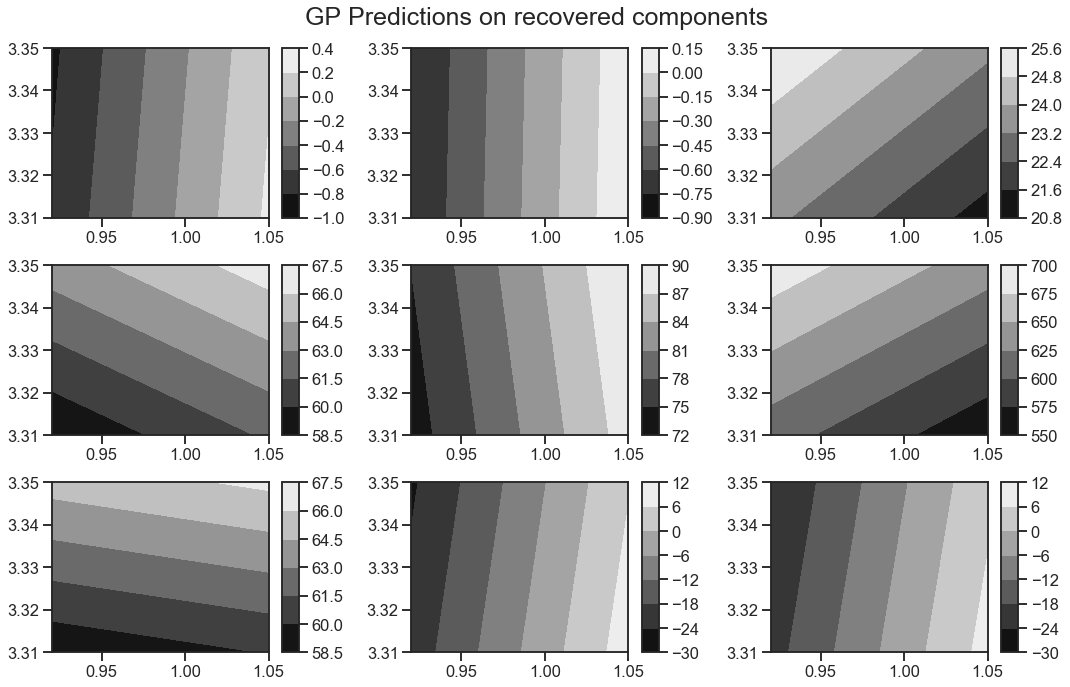

In [49]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (u.dot(gpmeans)[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [50]:
gplot, varplot = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

In [51]:
Hplot = ((gplot - u.T.dot(y_obs)[:,np.newaxis]) * \
         np.linalg.solve(2 * np.diag(d), gplot - u.T.dot(y_obs)[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)

for ii in tqdm(range(len(varplot.T))):
    Hplot_full[ii] = ((gplot[:,ii] - u.T.dot(y_obs)) * \
                      np.linalg.solve(2 * ( 0.0 * np.diag(d) + np.diag(varplot[:,ii])), 
                                      gplot[:,ii] - u.T.dot(y_obs))).sum() + \
                    0.5 * np.log(0.0 * d + varplot[:,ii]).sum()

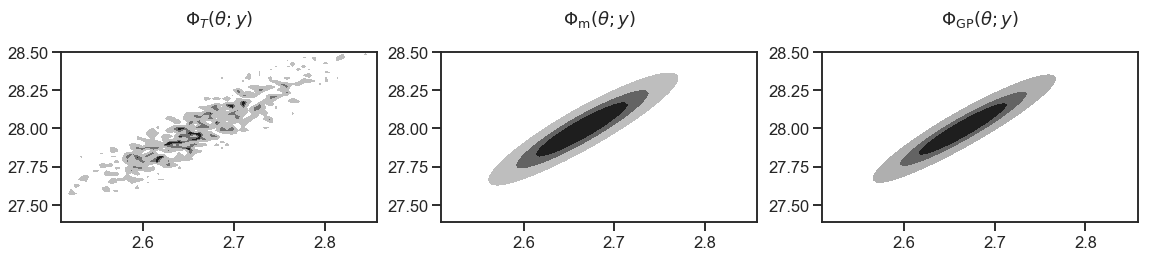

In [52]:
# The problem arises with levels_m <- take a look! 

fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot, Hplot_full, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_timediag_zoom'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [53]:
gpmodels['time-diag'] = enki.gpmodels
Hplots['time-diag'] = [np.copy(Hplot), np.copy(Hplot_full)]

<a id='par-var'></a>
# 2.4  Parameter variability

The EKS samples generate a set of training runs for the GP that can be stored in matrix form $G\in \mathbb{R}^{J\times p}$. Diagonalizing this matrix would account for parameter variability. Thus, we can compute an incomplete SVD decomposition of the form 

$$ G = \hat G D V^\top, $$

where all matrices are of comforming sizes. That is, $\hat G\in \mathbb{R}^{J \times p}$ and $D,V \in \mathbb{R}^{p \times p}$, where $D$ is an invertible diagonal matrix and $V$ is an orthogonal matrix.  

Note that every row in this matrix accounts for $G(\theta_j)^\top$ where $j = 1, \ldots, J$. So we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|\hat y - \hat G(\theta) \|^2_{\hat \Sigma}, 
\end{align}
$$

where $\hat y = D^{-1}V^\top \, y $, $\hat G(\theta) = D^{-1}V^\top \, G(\theta)$, and $\hat \Sigma = D^{-1}V^\top\Sigma V D^{-1}$

[go back](#contents)

In [68]:
mG     = enki.Gstar.mean(axis = 1).reshape(-1,1)
u,d,vh = np.linalg.svd((enki.Gstar - mG).T, full_matrices=False)
enki.Y = u.T
v = vh.T

In [55]:
VDh = np.diag(1./d).dot(vh)
S = np.matmul(VDh, np.matmul(Gamma, VDh.T))

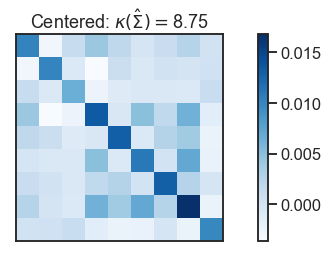

In [56]:
fig, axes = plt.subplots(1,1,figsize = (10,4))

im = axes.imshow(S, cmap = 'Blues');
plt.colorbar(im, ax= axes);
axes.set_yticks([])
axes.set_xticks([])
axes.set_title(r'Centered: $\kappa(\hat \Sigma) = $%s'%round(np.linalg.cond(S), 2))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [57]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in tqdm(enumerate(enki.Y[range(enki.n_obs)]), desc = 'GP training: ', total = enki.n_obs):
        with gp.defer_build():
            k  = gp.kernels.Matern52(input_dim = enki.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = 1./enki.J

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [58]:
emulate(enki)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.221432
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.221432
  Number of iterations: 52
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -94.550317
  Number of iterations: 85
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -94.550317
  Number of iterations: 85
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -98.143825
  Number of iterations: 60
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -98.143825
  Number of iterations: 60
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -105.922400
  Number of iterations: 73
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -105.922400
  Number of iterations: 73
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -92.520935
  Number of iterations: 83
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -92.520935
  Number of iterations: 83
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -107.555197
  Number of iterations: 141
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -107.555197
  Number of iterations: 141
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.674895
  Number of iterations: 93
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.674895
  Number of iterations: 93
  Number of functions evaluations: 119


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -102.913821
  Number of iterations: 74
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -102.913821
  Number of iterations: 74
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.294433
  Number of iterations: 89
  Number of functions evaluations: 117


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -87.294433
  Number of iterations: 89
  Number of functions evaluations: 117


In [59]:
gpmeans, gpvars = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

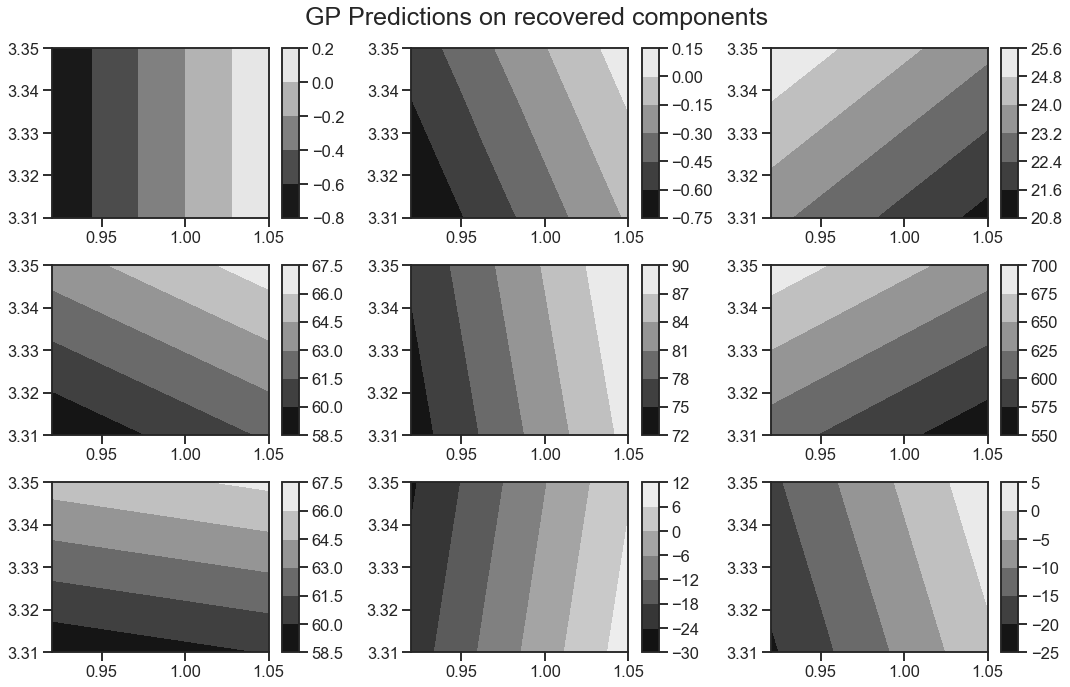

In [60]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

gpmeans_ = (np.matmul(vh.T, np.matmul(np.diag(d), gpmeans)) + mG)

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (gpmeans_[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [61]:
VDh = np.diag(1/d).dot(vh)

In [62]:
gplot, varplot = emu.predict_gps(enki, np.vstack([rs.flatten(), bs.flatten()]).T)

In [63]:
VD = v.dot(np.diag(d))
mG = enki.Gstar.mean(axis = 1).reshape(-1,1)
yG = VD.dot(gplot) + mG - y_obs.reshape(-1,1)

Hplot_rec = (yG * np.linalg.solve(2 * Gamma, yG)).sum(axis = 0)
Hplot_full_rec = np.empty(shape = Hplot_rec.shape)

for ii in tqdm(range(len(varplot.T)), desc = 'Grid points: '):
    Hplot_full_rec[ii] = ((yG[:,ii]) * np.linalg.solve(2 * VD.dot(np.diag(varplot[:,ii])).dot(VD.T), 
                                                       yG[:,ii])).sum() + \
                    0.5 * np.log(np.linalg.det(VD.dot(np.diag(varplot[:,ii])).dot(VD.T)))

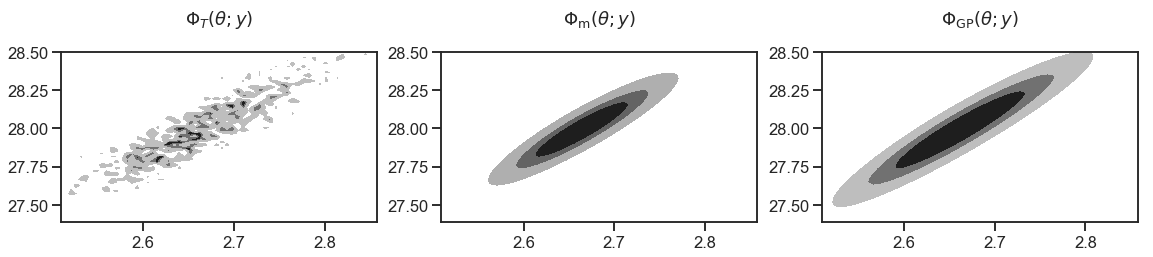

In [64]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_pcadiag_zoom'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [65]:
ytilde = VDh.dot((y_obs.reshape(-1,1) - mG))
Sigmatilde = VDh.dot(Gamma).dot(VDh.T)
gpmodels['pca-diag'] = enki.gpmodels
Hplots['pca-diag'] = [np.copy(Hplot_rec), np.copy(Hplot_full_rec)]

In [66]:
mG = enki.Gstar.mean(axis = 1).reshape(-1,1)
yG = gplot - ytilde

Hplot_rec = (yG * np.linalg.solve(2 * Sigmatilde, yG)).sum(axis = 0)
Hplot_full_rec = np.empty(shape = Hplot_rec.shape)

for ii in tqdm(range(len(varplot.T)), desc = 'Grid points: '):
    Hplot_full_rec[ii] = ((yG[:,ii]) * np.linalg.solve(2 * np.diag(varplot[:,ii]), yG[:,ii])).sum() + \
                    0.5 * np.log(np.linalg.det(np.diag(varplot[:,ii])))

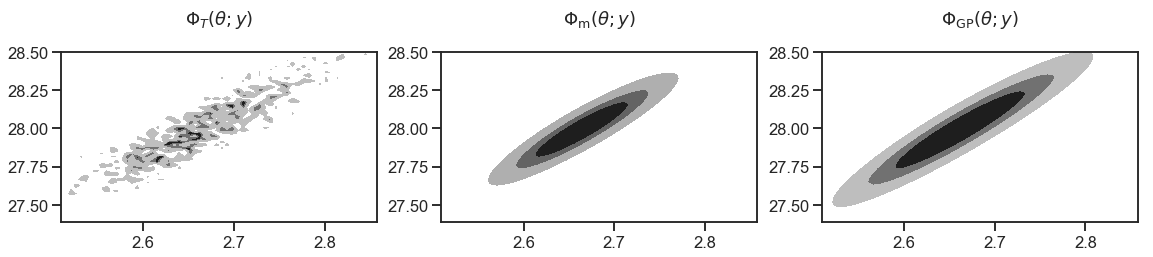

In [67]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='sample'></a>
# Sample

Use random walk metropolis with the GP emulators.

[go back](#contents)

In [69]:
enki.gpmodels = gpmodels['indp']

In [70]:
prior = multivariate_normal(mean = enki.mu.flatten(), cov = enki.sigma)

In [71]:
n_mcmc = 5000
mcmcs = {}
mcmc = MCMC()
mcmc.y_obs = y_obs
mcmc.gp_mh(enki, n_mcmc, prior, model = model)
mcmcs['indp'] = [mcmc]

In [72]:
mcmc = MCMC()
mcmc.y_obs = y_obs
mcmc.gp_mh(enki, n_mcmc, prior, Gamma = Gamma, model = model)
mcmcs['indp'].append(mcmc)

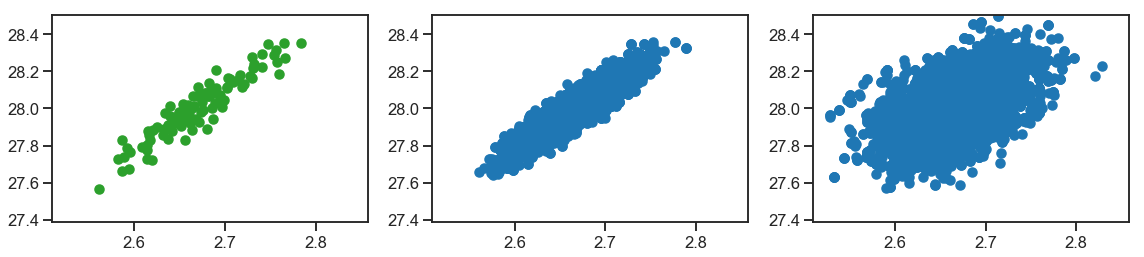

In [73]:
emu_type = 'indp'

fig, axes = plt.subplots(1,3, figsize = (16, 4))
# plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes) 
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [74]:
enki.gpmodels = gpmodels['time-diag']

mcmc = MCMC()
mcmc.y_obs = yhat
mcmc.gp_mh(enki, n_mcmc, prior, model = model)
mcmcs['time-diag'] = [mcmc]

In [75]:
mcmc = MCMC()
mcmc.y_obs = yhat
mcmc.gp_mh(enki, n_mcmc, prior, Gamma = Sigmahat, model = model)
mcmcs['time-diag'].append(mcmc)

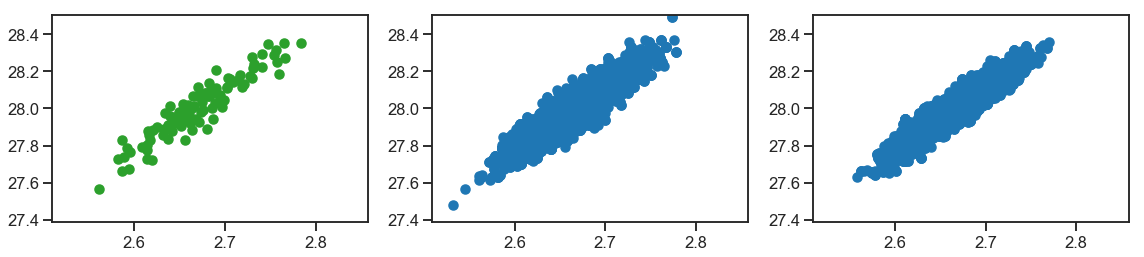

In [76]:
emu_type = 'time-diag'

fig, axes = plt.subplots(1,3, figsize = (16, 4))
# plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes) 
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [77]:
emu_type = 'pca-diag'

enki.gpmodels = gpmodels[emu_type]

mcmc = MCMC()
mcmc.y_obs = ytilde
mcmc.gp_mh(enki, n_mcmc, prior, model = model)
mcmcs[emu_type] = [mcmc]

In [78]:
mcmc = MCMC()
mcmc.y_obs = ytilde
mcmc.gp_mh(enki, n_mcmc, prior, Gamma = Sigmatilde, model = model)
mcmcs[emu_type].append(mcmc)

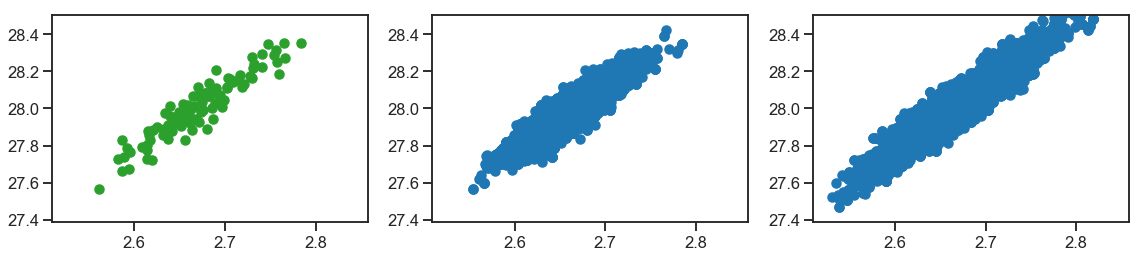

In [79]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
# plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes) 
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

[go back](#contents)

In [80]:
mcmc = MCMC()
mcmc.y_obs = y_obs
model.t = t_eks
model.wt= wt
mcmc.model_mh( model, n_mcmc, prior, enki, Gamma)

In [81]:
mcmcs['model'] = [mcmc]

In [82]:
list(mcmcs.keys())[:-1]

['indp', 'time-diag', 'pca-diag']

In [83]:
def kde_samples(enki, mcmcs, emu_type, axes): 
    sns.kdeplot(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', ax = axes[0], shade = True, shade_lowest=True, alpha = .5)
    sns.kdeplot(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', ax = axes[1], shade = True, shade_lowest=True, alpha = .5)
    sns.kdeplot(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', ax = axes[2], shade = True, shade_lowest=True, alpha = .5)
    sns.kdeplot(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]), ax = axes[2], shade = True, shade_lowest=True, alpha = .5, color = '#1f77b4')
    sns.kdeplot(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]), ax = axes[1], shade = True, shade_lowest=True, alpha = .5, color = '#1f77b4')
    sns.kdeplot(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c', ax = axes[0], shade = True, shade_lowest=True, alpha = .5)
    for ax in axes.flatten():
        ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

In [84]:
def scatter_samples(enki, mcmcs, emu_type, axes): 
    axes[0].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
    axes[1].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
    axes[2].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
    axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]),  marker = '+', s = 30, linewidth = 1,)
    axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]),  marker = '+', s = 30, linewidth = 1,)
    axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c',  marker = '+', s = 30, linewidth = 2)
#     for ax in axes.flatten():
#         ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

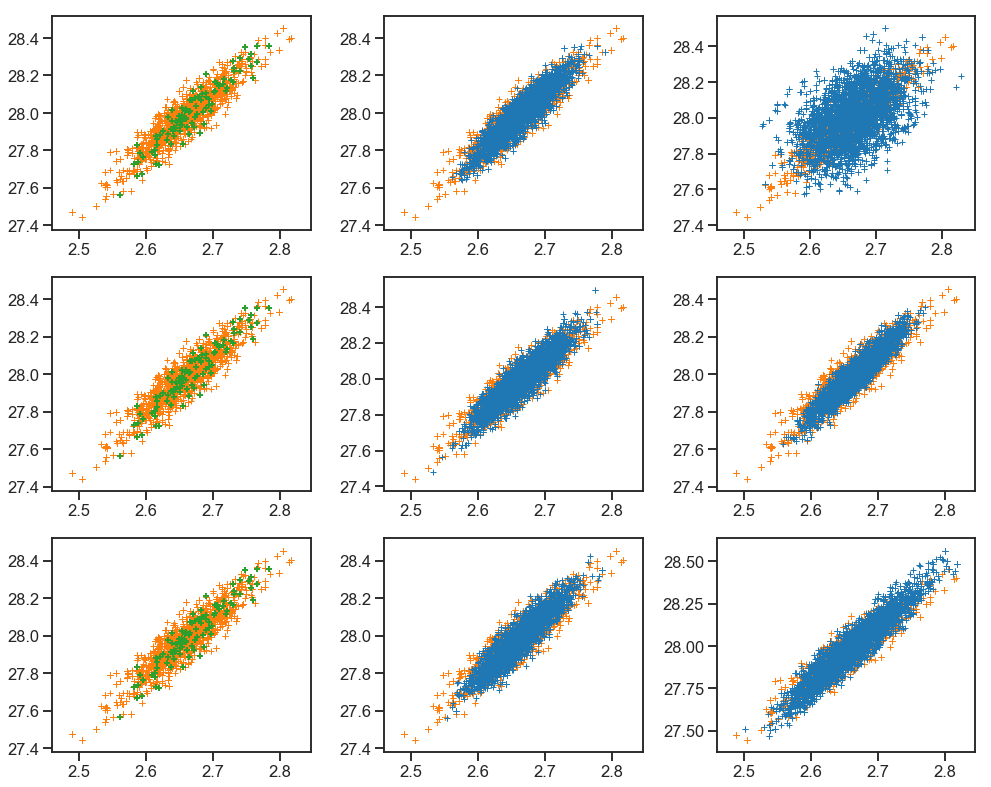

In [85]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (14,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
#     plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), k = 'Type: %s'%(emu_type)) 
    scatter_samples(enki, mcmcs, emu_type, axes[kk].flatten())

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-alt'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [86]:
grid_size = 60

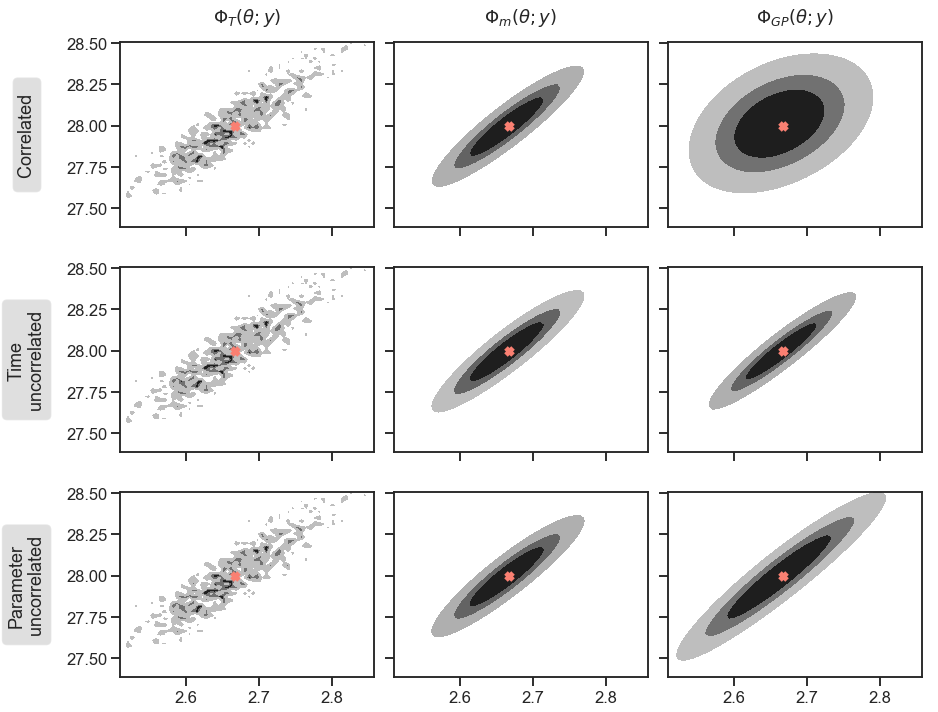

In [147]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]), 3, 
                         figsize = (13,10), sharex = True, sharey = True)

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), k = 'Type: %s'%(emu_type)) 
    
for ax in axes.flatten():
    ax.set_ylabel('')
    ax.scatter(np.exp(enki.ustar[1]), np.exp(enki.ustar[0]), marker = 'x', s = 50, linewidth = 5, color = 'salmon')
    ax.set_title('')
    
axes[0, 0].set_title(r"$\Phi_T(\theta;y)$", pad=20)
axes[0, 1].set_title(r"$\Phi_{m}(\theta;y)$", pad=20)    
axes[0, 2].set_title(r"$\Phi_{GP}(\theta;y)$", pad=20)  

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  


# axes[0, 0].set_ylabel(u"Independent \ncomponents", bbox=dict(facecolor='gray', alpha=0.25))
# axes[1, 0].set_ylabel(u"Time \ndiagonalization", bbox=dict(facecolor='gray', alpha=0.25))    
# axes[2, 0].set_ylabel(u"PCA \ndiagonzalization", bbox=dict(facecolor='gray', alpha=0.25))  
    
# plt.subplots_adjust(hspace = 0.25)
fig.tight_layout(h_pad = 2.2, w_pad = .2)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.5)

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-contours-labels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [88]:
def find_levels(x, y, contours = [.99, .90, .68], **kwargs):
    # Make a 2d normed histogram
    if kwargs.get('energy', None) is None: 
        H,xedges,yedges=np.histogram2d(x,y,bins=20,normed=True)
    else: 
        H = np.exp(-kwargs.get('energy'))
            
    norm=H.sum() # Find the norm of the sum
    # Set target levels as percentage of norm
    targets = [norm * c for c in contours]
    # Take histogram bin membership as proportional to Likelihood
    # This is true when data comes from a Markovian process
    def objective(limit, target):
        w = np.where(H>limit)
        count = H[w]
        return count.sum() - target

    # Find levels by summing histogram to objective
    levels = [opt.bisect(objective, H.min(), H.max(), args=(target,)) for target in targets]

    # For nice contour shading with seaborn, define top level
    levels.append(H.max())
    
    if kwargs.get('energy', None) is None:
        return levels
    else:
        return -np.log(levels)[::-1]

In [89]:
def plot_kde(x, y, ax, shade_lowest = False, alpha = .5, cmap = 'Blues'):
    sns.kdeplot(x, y, ax = ax, shade = True, shade_lowest=shade_lowest, 
                alpha = alpha, cmap = cmap, 
                n_levels = find_levels(x, y), 
                antialiased=True, normed=True, extend = 'both')

In [90]:
blues = ['#75b8e7', '#439fdf', '#258dd5', '#1f77b4', '#134b71'] 

In [91]:
import matplotlib as mpl

cmap_blues = mpl.cm.Blues(np.linspace(0,1,20))
cmap_blues = mpl.colors.ListedColormap(cmap_blues[5:,:-1])

cmap_oranges = mpl.cm.Oranges(np.linspace(0,1,20))
cmap_oranges = mpl.colors.ListedColormap(cmap_oranges[5:,:-1])

cmap_greys = mpl.cm.Greys(np.linspace(0,1,20))
cmap_greys = mpl.colors.ListedColormap(cmap_greys[5:,:-1][::-1])


In [92]:
def kde_samples(enki, mcmcs, emu_type, axes, shade_lowest = False, n_levels = 4, alpha = 1.): 
    plot_kde(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]), 
             axes[2], cmap = cmap_blues, alpha = alpha)
    plot_kde(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]),
             axes[1], cmap = cmap_blues, alpha = alpha)
    plot_kde(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), 
                axes[0], cmap = cmap_oranges, alpha = alpha)
    axes[0].scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c',  marker = '+', s = 30, linewidth = 2)
    
    axes[0].set_title(r'$\Phi_T(\theta; y)$'+'\n');
    axes[1].set_title(r'$\Phi_{\mathsf{m}}(\theta; y)$'+'\n');
    axes[2].set_title(r'$\Phi_{\mathsf{GP}}(\theta; y)$'+'\n');
    for ax in axes.flatten():
        ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
#         ax.scatter(np.exp(enki.Ustar[1]), np.exp(enki.Ustar[0]), color =  u'#2ca02c',  marker = '+', s = 30, linewidth = 2)

In [93]:
mcmcs

{'indp': [<ces.sample.MCMC at 0x13194d2b0>, <ces.sample.MCMC at 0x13194db38>],
 'time-diag': [<ces.sample.MCMC at 0x133ac54a8>,
 'pca-diag': [<ces.sample.MCMC at 0x1386dccf8>,
 'model': [<ces.sample.MCMC at 0x13d299748>]}

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'normed'
  s)


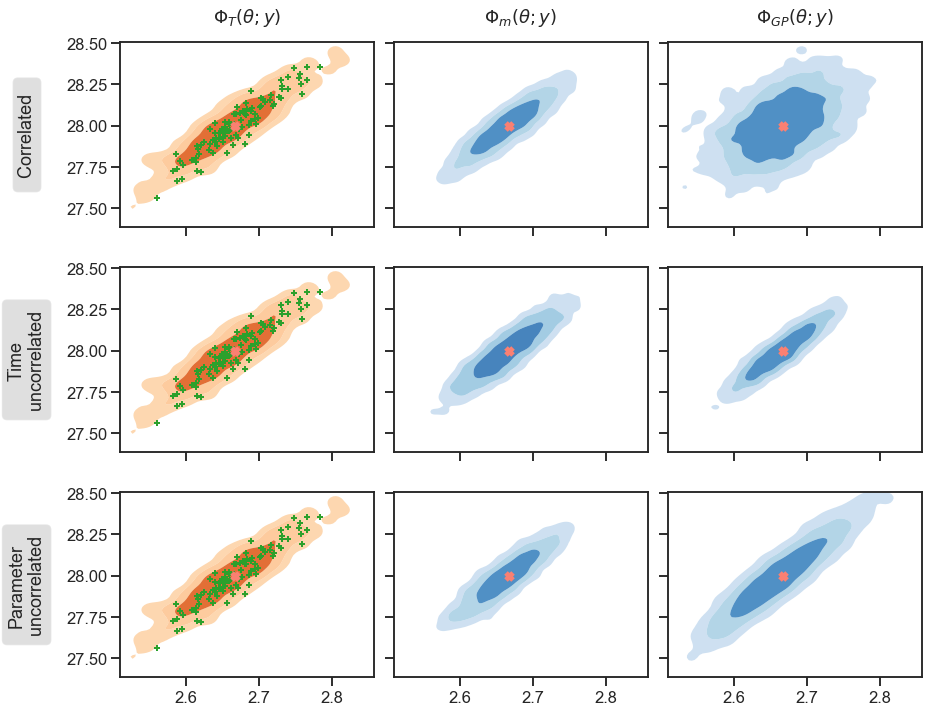

In [146]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (13,10), sharex = True, sharey = True)

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
#     plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), 
#                k = 'Type: %s'%(emu_type)) 
    kde_samples(enki, mcmcs, emu_type, axes[kk].flatten(), alpha = .8)
    
for ax in axes.flatten():
    ax.set_ylabel('')
    ax.scatter(np.exp(enki.ustar[1]), np.exp(enki.ustar[0]), marker = 'x', s = 50, linewidth = 5, color = 'salmon')
    ax.set_title('')
    
axes[0, 0].set_title(r"$\Phi_T(\theta;y)$", pad=20)
axes[0, 1].set_title(r"$\Phi_{m}(\theta;y)$", pad=20)    
axes[0, 2].set_title(r"$\Phi_{GP}(\theta;y)$", pad=20) 

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  

fig.tight_layout(h_pad = 2.2, w_pad = .2)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-kde-alt-labels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [95]:
for key in list(mcmcs.keys())[:-1]:
    tqdm.write('(%s, %s)'%(mcmcs[key][0].accept,mcmcs[key][1].accept))

(0.5768, 0.4716)
(0.433, 0.4574)
(0.5588, 0.4736)


In [96]:
accepts = np.array([(mcmcs[key][0].accept, mcmcs[key][1].accept) for key in list(mcmcs.keys())[:-1]])

In [97]:
mcmc.accept

0.1984

[go back](#contents)

In [90]:
import scipy.stats as stats

In [91]:
clevels = np.round(stats.chi2(df = enki.p).ppf(q = [.68, .90, .99]), 6)
clevels

array([2.278869, 4.60517 , 9.21034 ])

In [92]:
probs = {2.278869: r'$68\%$', 
         4.60517: r'$90\%$', 
         9.21034: r'$99\%$'}

In [93]:
def ellipse(mcmcs, emu_type, ix):
    mu = mcmcs[emu_type][ix].samples.mean(axis = 1)
    Sigma = np.cov(mcmcs[emu_type][ix].samples)
    xs_ = np.vstack([rs.flatten(), bs.flatten()])
    xs_mu = xs_ - mu.reshape(-1,1)
    dist = (xs_mu * np.linalg.solve(Sigma, xs_mu)).sum(axis = 0)
    return dist

In [94]:
def draw_ellipse(mcmcs, emu_type, axes, color = '#d62728'):
    im = axes[0].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, 'model', 0).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[0].clabel(im,  fmt = probs,  inline=1, fontsize=12);

    im = axes[1].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, emu_type, 1).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[1].clabel(im,  fmt = probs,  inline=1, fontsize=12);


    im = axes[2].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, emu_type, 0).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[2].clabel(im,  fmt = probs,  inline=1, fontsize=12);
    

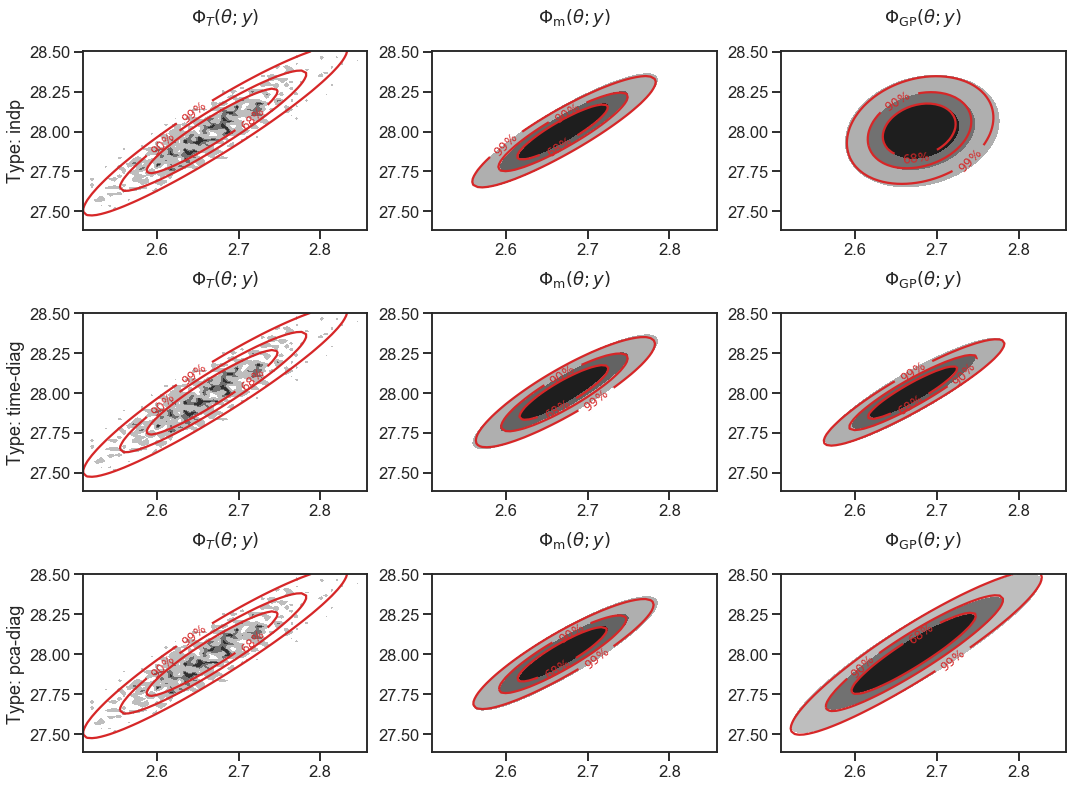

In [95]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (15,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), k = 'Type: %s'%(emu_type))
    draw_ellipse(mcmcs, emu_type, axes[kk].flatten())
#     scatter_samples(enki, mcmcs, emu_type, axes[kk].flatten())

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-contours-plevels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


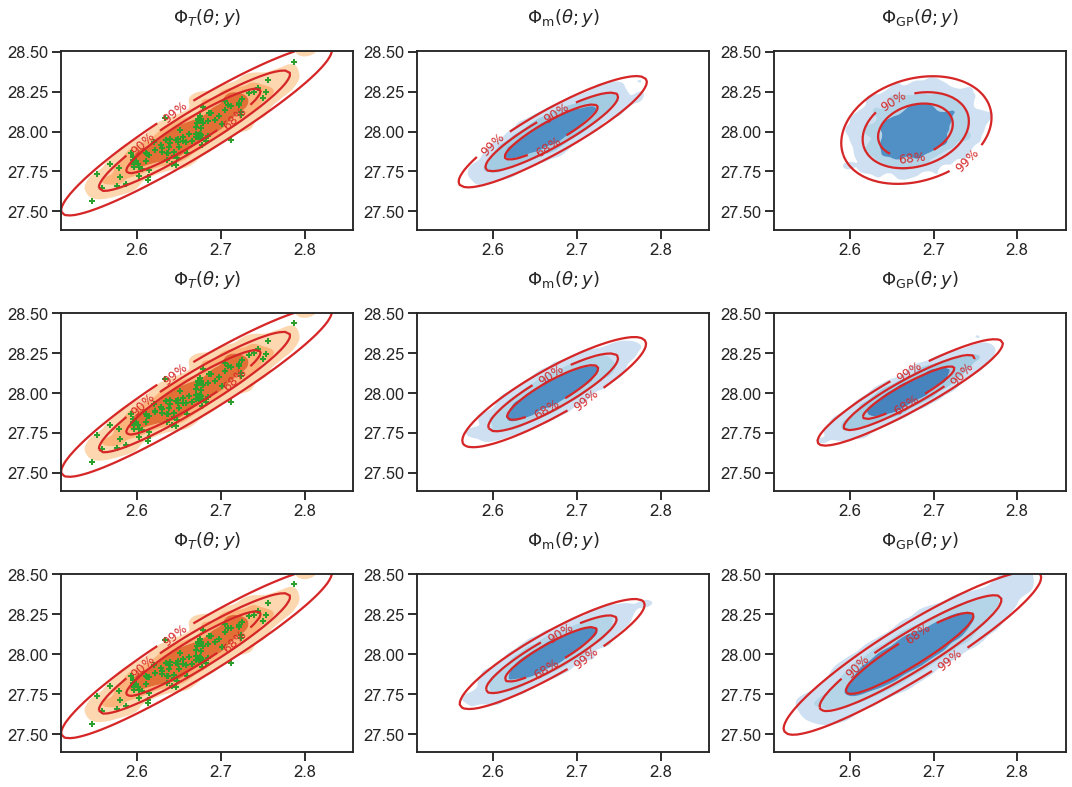

In [96]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (15,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    kde_samples(enki, mcmcs, emu_type, axes[kk].flatten(), alpha = .8)
    draw_ellipse(mcmcs, emu_type, axes[kk].flatten())
#     scatter_samples(enki, mcmcs, emu_type, axes[kk].flatten())

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-kde-plevels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

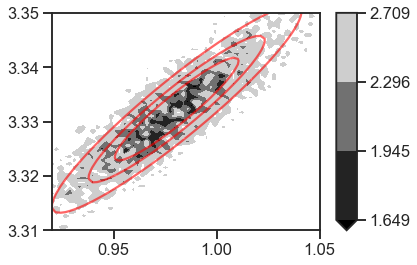

In [97]:
im = plt.contourf(bs, rs,  np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
             np.exp(np.linspace(0.5, .996471074, 4)), extend = 'min',
             cmap = cmap)
plt.colorbar(im, cmap = cmap, aspect = 10)
im = plt.contour(bs, rs, ellipse(mcmcs, 'model', 0).reshape(grid_size, grid_size), clevels, 
                         colors = "red", alpha = .6, extend = "both");
# plt.clabel(im,  fmt = probs,  inline=1, fontsize=12);

In [98]:
np.log(np.linspace(1.4, 2.4, 5))

array([0.33647224, 0.50077529, 0.64185389, 0.76546784, 0.87546874])

In [99]:
np.exp(np.linspace(-0.22314355, 1.06471074, 4))

array([0.8       , 1.22892673, 1.88782614, 2.90000001])